In [1]:
from makiflow.layers import *
from makizoo.backbones.vgg import VGG16
import makizoo as mz
from makiflow.base import MakiModel
import tensorflow as tf
import numpy as np
import makiflow as mf
mf.set_main_gpu(1)

In [2]:
batch_size=32

In [3]:
from makiflow.base.base_layers import BatchNormBaseLayer
class BatchNormLayer(BatchNormBaseLayer):
    def __init__(self, D, name, decay=0.9, eps=1e-4, use_gamma=True,
                 use_beta=True, mean=None, var=None, gamma=None, beta=None):
        """
        Batch Normalization Procedure:
            X_normed = (X - mean) / variance
            X_final = X*gamma + beta
        gamma and beta are defined by the NN, e.g. they are trainable.

        Parameters
        ----------
        D : int
            Number of tensors to be normalized.
        decay : float
            Decay (momentum) for the moving mean and the moving variance.
        eps : float
            A small float number to avoid dividing by 0.
        use_gamma : bool
            Use gamma in batchnorm or not.
        use_beta : bool
            Use beta in batchnorm or not.
        name : str
            Name of this layer.
        mean : float
            Batch mean value. Used for initialization mean with pretrained value.
        var : float
            Batch variance value. Used for initialization variance with pretrained value.
        gamma : float
            Batchnorm gamma value. Used for initialization gamma with pretrained value.
        beta : float
            Batchnorm beta value. Used for initialization beta with pretrained value.
        """
        super().__init__(D=D, decay=decay, eps=eps, name=name, use_gamma=use_gamma, use_beta=use_beta,
                         type_norm='Batch', mean=mean, var=var, gamma=gamma, beta=beta)

    def _init_train_params(self, data):
        if self.running_mean is None:
            self.running_mean = np.zeros(self.D)
        if self.running_variance is None:
            self.running_variance = np.ones(self.D)

        name = str(self._name)

        self.name_mean = 'BatchMean_{}_id_'.format(self.D) + name
        self.name_var = 'BatchVar_{}_id_'.format(self.D) + name

        self.running_mean = tf.Variable(self.running_mean, trainable=False, name=self.name_mean, dtype=tf.float32)
        self._named_params_dict[self.name_mean] = self.running_mean

        self.running_variance = tf.Variable(self.running_variance, trainable=False,
                                            name=self.name_var, dtype=tf.float32)
        self._named_params_dict[self.name_var] = self.running_variance

    def _forward(self, X):
        return tf.nn.batch_normalization(
            X,
            self.running_mean,
            self.running_variance,
            self.beta,
            self.gamma,
            self.eps
        )

    def _training_forward(self, X):
        # These if statements check if we do batchnorm for convolution or dense
        if len(X.shape) == 4:
            # conv
            axes = [0, 1, 2]
        else:
            # dense
            axes = [0]

        batch_mean, batch_var = tf.nn.moments(X, axes=axes)
        update_running_mean = tf.assign(
            self.running_mean,
            self.running_mean * self.decay + batch_mean * (1 - self.decay)
        )
        update_running_variance = tf.assign(
            self.running_variance,
            self.running_variance * self.decay + batch_var * (1 - self.decay)
        )
        with tf.control_dependencies([update_running_mean, update_running_variance]):
            out = tf.nn.batch_normalization(
                X,
                batch_mean,
                batch_var,
                self.beta,
                self.gamma,
                self.eps
            )

        return out

    def to_dict(self):
        return {
            'type': 'BatchNormLayer',
            'params': {
                'name': self._name,
                'D': self.D,
                'decay': self.decay,
                'eps': self.eps,
                'use_beta': self.use_beta,
                'use_gamma': self.use_gamma,
            }
        }

In [4]:
import tensorflow as tf
from makizoo.backbones.densenet.blocks import transition_layer, dense_block
from makizoo.backbones.densenet.utils import get_batchnorm_params

from makiflow.layers import *
from makiflow.models import Classificator

def build_DenseNet(in_x,
        input_shape,
        nb_layers=[6,12,24,16],
        depth=121,
        include_top=False,
        num_classes=1000,
        use_bias=False,
        use_bottleneck=True,
        subsample_initial_block=True,
        activation=tf.nn.relu,
        create_model=False,
        name_model='MakiClassificator',
        growth_rate=32,
        reduction=0.0,
        nb_blocks=3,
        dropout_p_keep=None,
        bn_params={}
    ):
    """
     Parameters
     ----------
     x : MakiTensor
         Input MakiTensor.
     nb_layers : int
         List of lenght 4, where `nb_layers[i]` is number of repetition layers at stage `i` (i from 0 to 3).
    depth : int
        If list `nb_layers` will be empty, number of blocks will be calculated based on `depth`
        For example: if depth=40, then first 4 blocks will repeat repeat_times = int((depth - 4) / 3), if use_bottleneck is True when
        repeat_times divide by 2, in these example repeat_times = 6, so `nb_layers` = [6,6,6,6] in these example.
    growth_rate : int
        Coefficient `k` from original papep, https://arxiv.org/pdf/1608.06993.pdf .
    dropout_p_keep : float
        The probability that each element of x is not discarded.
    reduction : float
        Coefficient, where `r` = 1 - `rediction`, `r` is how much number of feature maps need to compress in transition layers.
    input_shape : List
        Input shape of neural network. Example - [32, 128, 128, 3]
        which mean 32 - batch size, two 128 - size of picture, 3 - number of colors.
    create_model : bool
        Return build classification model, otherwise return input MakiTensor and output MakiTensor.
    name_model : str
        Name of model, if it will be created.
    nb_blocks : int
        Number of dense blocks.
    num_classes : int
        Number of classes that you need to classify.
    bn_params : dict
        Parameters for BatchNormLayer. If empty all parameters will have default valued.
    include_top : bool
        If true when at the end of the neural network added Global Avg pooling and Dense Layer without
        activation with the number of output neurons equal to num_classes.
    activation : tensorflow function
        The function of activation, by default tf.nn.relu.

     Returns
     ---------
     in_x : MakiTensor
         Input MakiTensor.
     output : int
         Output MakiTensor.
     Classificator : MakiFlow.Classificator
         Constructed model.
     """
    if bn_params is None or len(bn_params) == 0:
        bn_params = get_batchnorm_params()
    compression = 1 - reduction

    if len(nb_layers) == 0:
        count = int((depth - 4) / 3)
        nb_layers = [count for _ in range(nb_blocks+1)]

    if subsample_initial_block:
        x = ZeroPaddingLayer(padding=[[3,3],[3,3]], name='zero_padding2d_4')(in_x)

        x = ConvLayer(kw=7,kh=7,in_f=3, stride=2, out_f=growth_rate * 2, activation=None, use_bias=use_bias,
                name='conv1/conv', padding='VALID')(x)

        x = BatchNormLayer(D=growth_rate * 2, name='conv1/bn', **bn_params)(x)
        x = ActivationLayer(activation=activation, name='conv1/relu')(x)
        x = ZeroPaddingLayer(padding=[[1,1],[1,1]], name='zero_padding2d_5')(x)

        x = MaxPoolLayer(ksize=[1,3,3,1], padding='VALID', name='pool1')(x)
    else:
        x = ConvLayer(kw=3,kh=3,in_f=3, stride=1, out_f=growth_rate * 2, activation=None, use_bias=use_bias,
                name='conv1/conv')(in_x)

    # densenet blocks
    for block_index in range(len(nb_layers) - 1):
        # dense block
        x = dense_block(x=x, nb_layers=nb_layers[block_index], stage=block_index+2,
                growth_rate=growth_rate, dropout_p_keep=dropout_p_keep, use_bottleneck=use_bottleneck,
                        activation=activation, use_bias=use_bias, bn_params=bn_params)

        # transition block
        x = transition_layer(x=x,
             dropout_p_keep=dropout_p_keep, number=block_index+2, compression=compression,
                        activation=activation, use_bias=use_bias, bn_params=bn_params)

    x = dense_block(x=x, nb_layers=nb_layers[-1], stage=len(nb_layers)+1,
            growth_rate=growth_rate, dropout_p_keep=dropout_p_keep, use_bottleneck=use_bottleneck,
                        activation=activation, use_bias=use_bias, bn_params=bn_params)

    x = BatchNormLayer(D=x.get_shape()[-1], name='bn', **bn_params)(x)
    x = ActivationLayer(activation=activation, name='relu')(x)
    if include_top:
        x = GlobalAvgPoolLayer(name='avg_pool')(x)
        # dense part (fc layers)
        output = DenseLayer(in_d=x.get_shape()[-1], out_d=num_classes, activation=None, use_bias=True, name="fc1000")(x)
        if create_model:
            return Classificator(in_x, output, name_model)
    else:
        output = x

    return GlobalAvgPoolLayer(name='avg_pool')(output)



In [5]:
image_size=32

def preprocess_densenet(x):
    return build_DenseNet(in_x=x,
        input_shape=[batch_size,image_size,image_size,3],
        nb_layers=[6, 12, 24, 16],
        include_top=False,
        num_classes=1,
        use_bias=False,
        use_bottleneck=True,
        subsample_initial_block=True,
        activation=tf.nn.relu,
        create_model=False,
        name_model='DenseNet121',
        growth_rate=32,
        reduction=0.5,
        dropout_p_keep=0.8,
        bn_params={})

In [6]:
in_x1 = InputLayer(input_shape=[batch_size,None,None,3],name='Input1')
in_x2 = InputLayer(input_shape=[batch_size,None,None,3],name='Input2')
    

In [7]:
out1 = preprocess_densenet(in_x1)
out2 = preprocess_densenet(in_x2)

In [8]:
out1.get_shape()

[32, 1024]

In [9]:
layers = list(out1.get_previous_tensors()) + [out1.get_name()]
layers

['Input1',
 'zero_padding2d_4',
 'conv1/conv',
 'conv1/bn',
 'conv1/relu',
 'zero_padding2d_5',
 'pool1',
 'conv2_block1_0_bn',
 'conv2_block1_0_relu',
 'conv2_block1_1_conv',
 'conv2_block1_1_dropout',
 'conv2_block1_1_bn',
 'conv2_block1_1_relu',
 'conv2_block1_2_conv',
 'conv2_block1_2_dropout',
 'conv2_block1_concat',
 'conv2_block2_0_bn',
 'conv2_block2_0_relu',
 'conv2_block2_1_conv',
 'conv2_block2_1_dropout',
 'conv2_block2_1_bn',
 'conv2_block2_1_relu',
 'conv2_block2_2_conv',
 'conv2_block2_2_dropout',
 'conv2_block2_concat',
 'conv2_block3_0_bn',
 'conv2_block3_0_relu',
 'conv2_block3_1_conv',
 'conv2_block3_1_dropout',
 'conv2_block3_1_bn',
 'conv2_block3_1_relu',
 'conv2_block3_2_conv',
 'conv2_block3_2_dropout',
 'conv2_block3_concat',
 'conv2_block4_0_bn',
 'conv2_block4_0_relu',
 'conv2_block4_1_conv',
 'conv2_block4_1_dropout',
 'conv2_block4_1_bn',
 'conv2_block4_1_relu',
 'conv2_block4_2_conv',
 'conv2_block4_2_dropout',
 'conv2_block4_concat',
 'conv2_block5_0_bn',


In [10]:
#concat = ConcatLayer(name='concat', axis=-1)([out1, out2])
concat = SumLayer(name='sum')([out1, out2])

In [11]:
concat.get_shape()

[32, 1024]

In [12]:
#x = FlattenLayer('flatten1')(x)

#dense1 = DropoutLayer(p_keep=0.5, name='drop0_starto')(concat)
#dense1 = DenseLayer(in_d=1536, out_d=512, activation=None,use_bias=False, name='dense1')(concat)
#dense1 = BatchNormLayer(D=256, name='bn1_dense')(dense1)
#dense1 = ActivationLayer('act1_dense', activation=tf.nn.leaky_relu)(dense1)
#dense1 = DropoutLayer(p_keep=0.7, name='drop1')(dense1)

#dense2 = DenseLayer(in_d=512, out_d=512, activation=None,use_bias=False,name='dense2')(dense1)
#dense2 = BatchNormLayer(D=512, name='bn2_dense')(dense2)
#dense2 = ActivationLayer('act2_dense')(dense2)
#dense2 = DropoutLayer(p_keep=0.75, name='drop2')(dense2)

#dense3 = DenseLayer(in_d=256, out_d=128, activation=None,use_bias=False,name='dense3')(dense1)
#dense3 = BatchNormLayer(D=128, name='bn3_dense')(dense3)
#dense3 = ActivationLayer('act3_dense', activation=tf.nn.leaky_relu)(dense3)
#dense3 = DropoutLayer(p_keep=0.7, name='drop3')(dense3)

#dense4 = DenseLayer(in_d=256, out_d=256, activation=None,use_bias=False,name='dense4')(dense3)
#dense4 = BatchNormLayer(D=256, name='bn4_dense')(dense4)
#dense4 = ActivationLayer('act4_dense')(dense4)
#dense3 = DropoutLayer(p_keep=0.75, name='drop3')(dense3)

#dense5 = DenseLayer(in_d=1024, out_d=512, activation=None,use_bias=False,name='dense5')(concat)
#dense5 = BatchNormLayer(D=512, name='bn5')(dense5)
#dense5 = ActivationLayer('act5_dense')(dense5)
#dense5 = DropoutLayer(p_keep=0.7, name='drop5_dense')(dense5)

dense6 = DenseLayer(in_d=1024, out_d=1024, activation=None,use_bias=False,name='dense6')(concat)
#dense6 = BatchNormLayer(D=1024, name='bn4')(dense6)
dense6 = ActivationLayer('act56_dense', activation=tf.nn.leaky_relu)(dense6)
dense6 = DropoutLayer(p_keep=0.5, name='drop6_dense')(dense6)
dense7 = DenseLayer(in_d=1024, out_d=1, activation=None, name='criteria')(dense6)

In [13]:
concat.get_shape()

[32, 1024]

In [14]:
from copy import copy 
from sklearn.utils import shuffle
from tqdm import tqdm

class Regressor(MakiModel):
    def __init__(self, in_x1, in_x2, out_x, name='Regressor'):
        graph_tensors = copy(out_x.get_previous_tensors())
        # Add output tensor to `graph_tensors` since it doesn't have it.
        # It is assumed that graph_tensors contains ALL THE TENSORS graph consists of.
        graph_tensors.update(out_x.get_self_pair())
        outputs = [out_x]
        inputs = [in_x1, in_x2]
        super().__init__(graph_tensors, outputs, inputs)
        self.name = str(name)
        self._batch_sz = in_x1.get_shape()[0]
        self._images1 = self._input_data_tensors[0]
        self._images2 = self._input_data_tensors[1]
        self._inference_out = self._output_data_tensors[0]
        # For training
        self._training_vars_are_ready = False

    def _prepare_training_vars(self):
        if not self._set_for_training:
            super()._setup_for_training()

        self._logits = self._training_outputs[0]
        self._num_classes = self._logits.get_shape()[-1]
        self._labels = tf.placeholder(tf.float32, shape=[self._batch_sz, 1])
        
        self._training_vars_are_ready = True
        self._ce_loss_is_build =False
        
    def _build_ce_loss(self):
        self._final_ce_loss = tf.reduce_mean(
            tf.abs(self._labels - self._logits)
        )

        self._ce_loss_is_build = True

    def _minimize_ce_loss(self, optimizer, global_step):
        if not self._set_for_training:
            super()._setup_for_training()

        if not self._training_vars_are_ready:
            self._prepare_training_vars()

        if not self._ce_loss_is_build:
            # no need to setup any inputs for this loss
            self._build_ce_loss()
            self._ce_optimizer = optimizer
            self._ce_train_op = optimizer.minimize(
                self._final_ce_loss, var_list=self._trainable_vars, global_step=global_step
            )
            self._session.run(tf.variables_initializer(optimizer.variables()))

        if self._ce_optimizer != optimizer:
            print('New optimizer is used.')
            self._ce_optimizer = optimizer
            self._ce_train_op = optimizer.minimize(
                self._final_ce_loss, var_list=self._trainable_vars, global_step=global_step
            )
            self._session.run(tf.variables_initializer(optimizer.variables()))

        return self._ce_train_op

    def fit_ce(
            self, Xtraina, Xtrainb, Ytrain, Xtesta, Xtestb, Ytest, optimizer=None, epochs=1, global_step=None
    ):
        """
        Method for training the model. Works faster than `verbose_fit` method because
        it uses exponential decay in order to speed up training. It produces less accurate
        train error mesurement.
        Parameters
        ----------
            Xtrain : numpy array
                Training images stacked into one big array with shape (num_images, image_w, image_h, image_depth).
            Ytrain : numpy array
                Training label for each image in `Xtrain` array with shape (num_images).
                IMPORTANT: ALL LABELS MUST BE NOT ONE-HOT ENCODED, USE SPARSE TRAINING DATA INSTEAD.
            Xtest : numpy array
                Same as `Xtrain` but for testing.
            Ytest : numpy array
                Same as `Ytrain` but for testing.
            optimizer : tensorflow optimizer
                Model uses tensorflow optimizers in order train itself.
            epochs : int
                Number of epochs.
            test_period : int
                Test begins each `test_period` epochs. You can set a larger number in order to
                speed up training.
        Returns
        -------
            python dictionary
                Dictionary with all testing data(train error, train cost, test error, test cost)
                for each test period.
        """

        assert (optimizer is not None)
        assert (self._session is not None)
        train_op = self._minimize_ce_loss(optimizer, global_step)

        n_batches = len(Xtraina) // self._batch_sz
        bs = self._batch_sz

        train_costs = []
        train_errors = []
        test_costs = []
        iterator = None
        train_cost = np.float32(0)
        for i in range(epochs):
            Xtraina, Xtrainb, Ytrain = shuffle(Xtraina,Xtrainb, Ytrain)
            iterator = tqdm(range(n_batches))

            for j in iterator:
                Xbatcha = Xtraina[j*bs:(j+1)*bs]
                Xbatchb = Xtrainb[j*bs:(j+1)*bs]
                Ybatch = Ytrain[j*bs:(j+1)*bs]
                train_cost_batch, _ = self._session.run(
                    [self._final_ce_loss, train_op],
                    feed_dict={
                        self._images1: Xbatcha,
                        self._images2: Xbatchb,
                        self._labels: Ybatch
                    })

            train_costs.append(train_cost)
            test_cost = 0
            for j in range(len(Xtesta) // bs):
                Xbatcha = Xtesta[j*bs:(j+1)*bs]
                Xbatchb = Xtestb[j*bs:(j+1)*bs]
                Ybatch = Ytest[j*bs:(j+1)*bs]
                test_cost += self._session.run(
                    [self._final_ce_loss],
                    feed_dict={
                        self._images1: Xbatcha,
                        self._images2: Xbatchb,
                        self._labels: Ybatch
                    })[0]
            test_costs.append(test_cost)
            train_cost = 0
            for j in range(len(Xtraina) // bs):
                Xbatcha = Xtraina[j*bs:(j+1)*bs]
                Xbatchb = Xtrainb[j*bs:(j+1)*bs]
                Ybatch = Ytrain[j*bs:(j+1)*bs]
                train_cost += self._session.run(
                    [self._final_ce_loss],
                    feed_dict={
                        self._images1: Xbatcha,
                        self._images2: Xbatchb,
                        self._labels: Ybatch
                    })[0]
            
            print('Epoch:', i,
                  'Train cost: {:0.4f}'.format(train_cost / (len(Xtraina) // bs)),
                  'Test cost: {:0.4f}'.format(test_cost / (len(Xtesta) // bs)),
                 )
        if iterator is not None:
            iterator.close()
        return {'train costs': train_costs, 'train errors': train_errors}
        
    def predict(self, val):
        return self._session.run(
            self._inference_out,
            feed_dict={
                self._images1: val[0],
                self._images2: val[1]
            }
        )

In [15]:
model = Regressor(in_x1, in_x2, out_x=dense7)

In [16]:
ses = tf.Session()

In [17]:
model.set_session(ses)

In [18]:
layers = [
    'conv1/conv1_1',
		 'conv1/conv1_2',
		 'block1_pool',
		 'conv2/conv2_1',
		 'conv2/conv2_2',
		 'block2_pool',
		 'conv3/conv3_1',
		 'conv3/conv3_2',
		 'conv3/conv3_3',
		 'block3_pool',
		 'conv4/conv4_1',
		 'conv4/conv4_2',
		 'conv4/conv4_3',
		 'block4_pool',
		 'conv5/conv5_1',
		 'conv5/conv5_2',
		 'conv5/conv5_3',
]

In [19]:
#model.load_weights('/home/ikilbas/USA/weights/vgg16/model_vgg16.ckpt', layer_names=[])

In [20]:
layers = []

In [21]:
model.set_layers_trainable([(l, False) for l in layers])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
import numpy as np

In [23]:
global_step = tf.Variable(0, trainable=False)


def get_cosine_decay(lr, steps=10,t_mul=2.0,m_mul=1.0,alpha=1e-4):
    global global_step, one_epoch
    return tf.train.cosine_decay_restarts(learning_rate=lr,
        global_step=global_step,
        first_decay_steps=39*steps,
        t_mul=t_mul,
        m_mul=m_mul,
        alpha=alpha,
        name='supa_optimizer_lr')

In [24]:
#opt = tf.train.AdamOptimizer(learning_rate=5e-4, epsilon=1e-2)
opt = tf.train.MomentumOptimizer(learning_rate=get_cosine_decay(5e-2),momentum=0.9,use_nesterov=True)

In [25]:
ses.run(tf.initialize_variables([global_step]))

Instructions for updating:
Use `tf.variables_initializer` instead.


In [26]:
import pandas as pd

In [27]:
df = pd.DataFrame.from_csv('/mnt/data/nn_matching/DatasetNN_02/res_2.csv', sep=';')
df2 = pd.DataFrame.from_csv('/mnt/data/nn_matching/DatasetNN_06/res_2.csv', sep=';')
df3 = pd.DataFrame.from_csv('/mnt/data/nn_matching/DatasetNN_03/res_2.csv', sep=';')

/home/ikilbas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
/home/ikilbas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/home/ikilbas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports unti

In [28]:
df2.head()

,cryteria,pairs,blur,threshold
folder,,,,
5001,0.064932,5,23,100
5006,0.054266,9,29,127
5006,0.054266,9,29,128
5006,0.054266,9,33,128
5007,0.043527,5,21,186


In [29]:
import matplotlib.pyplot as plt


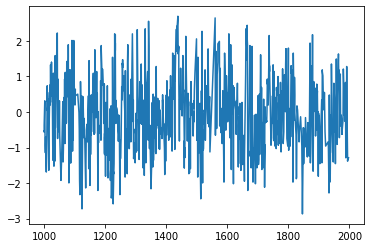

In [30]:
plt.plot((df['threshold'] - df['threshold'].mean()) / df['threshold'].std())

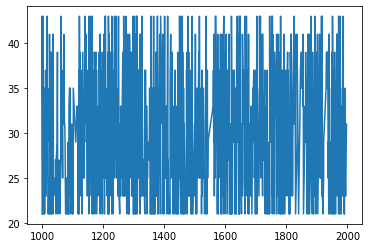

In [31]:
plt.plot((df['blur']))# - df['blur'].mean()) / df['blur'].std())

In [32]:
import cv2
import numpy as np

In [33]:
uniq, counts = np.unique(df.index, return_counts=True)
uniq2, counts2 = np.unique(df2.index, return_counts=True)
uniq3, counts3 = np.unique(df3.index, return_counts=True)

In [34]:
single_values = uniq[counts==1]
single_values2 = uniq2[counts2==1]
single_values3 = uniq3[counts3==1]

In [35]:
import os

def preprocess_input2(x):
    #size = (x.shape[1] // 2, x.shape[0] // 2)
    x = cv2.resize(x, (image_size, image_size)).astype(np.float32)
    #mean = [103.939, 116.779, 123.68]
    # x = x[...,::-1]
    #x[..., 0] = x[..., 0] - mean[0]
    #x[..., 1] = x[..., 1] - mean[1]
    #x[..., 2] = x[..., 2] - mean[2]
    x = ((x / 128) - 1).astype(np.float32)
    return x

In [36]:
imgsa = []
imgsb = []
for folder_name in single_values:
    path = os.path.join('/mnt/data/nn_matching/DatasetNN_02/', str(folder_name), 'original')
    im_1 = os.path.join(path, '1.jpg')
    im_2 = os.path.join(path, '2.jpg')
    imgsa += [preprocess_input2(cv2.imread(im_1))]
    imgsb += [preprocess_input2(cv2.imread(im_2))]



In [37]:
for folder_name in single_values2:
    path = os.path.join('/mnt/data/nn_matching/DatasetNN_06/', str(folder_name), 'original')
    im_1 = os.path.join(path, '1.jpg')
    im_2 = os.path.join(path, '2.jpg')
    imgsa += [preprocess_input2(cv2.imread(im_1))]
    imgsb += [preprocess_input2(cv2.imread(im_2))]

In [38]:
for folder_name in single_values3:
    path = os.path.join('/mnt/data/nn_matching/DatasetNN_03/', str(folder_name), 'original')
    im_1 = os.path.join(path, '1.jpg')
    im_2 = os.path.join(path, '2.jpg')
    imgsa += [preprocess_input2(cv2.imread(im_1))]
    imgsb += [preprocess_input2(cv2.imread(im_2))]

In [39]:
name_type = ['blur', 'threshold']

In [40]:
blur = df[name_type[1]][single_values].values# - df['blur'][single_values].values.mean()) / df['blur'][single_values].values.std()

In [41]:
blur2 = df2[name_type[1]][single_values2].values# - df2['blur'][single_values2].values.mean()) / df2['blur'][single_values2].values.std()

In [42]:
blur3 = df3[name_type[1]][single_values3].values# - df2['blur'][single_values2].values.mean()) / df2['blur'][single_values2].values.std()

In [43]:
bl = np.concatenate([blur, blur2, blur3])

In [44]:
bl = bl - bl.mean()

In [45]:
output = model._graph_tensors

In [46]:
names = [name for name,value in output.items()]

In [47]:
train_layers = []
for elem in names:
    if elem not in layers:
        train_layers.append(elem)

In [48]:
#model.set_l1_reg([(name,1e-5) for name in train_layers])
model.set_l2_reg([(name,1e-4) for name in train_layers])

In [ ]:
info = model.fit_ce(imgsa[:-100], imgsb[:-100], bl.reshape(-1, 1)[:-100], 
                    imgsa[-100:], imgsb[-100:], bl.reshape(-1, 1)[-100:],
                    opt, epochs=100, global_step=global_step)

  5%|▌         | 2/39 [00:00<00:03, 11.61it/s]

Epoch: 0 Train cost: 30.3264 Test cost: 22.2700


  5%|▌         | 2/39 [00:00<00:03, 12.22it/s]

Epoch: 1 Train cost: 24.9116 Test cost: 22.0370


  3%|▎         | 1/39 [00:00<00:04,  8.69it/s]

Epoch: 2 Train cost: 19.6965 Test cost: 18.9151


  5%|▌         | 2/39 [00:00<00:03, 11.24it/s]

Epoch: 3 Train cost: 19.7497 Test cost: 16.9927


  3%|▎         | 1/39 [00:00<00:03,  9.52it/s]

Epoch: 4 Train cost: 18.8368 Test cost: 16.2581


  5%|▌         | 2/39 [00:00<00:03, 11.68it/s]

Epoch: 5 Train cost: 23.6828 Test cost: 23.0684


  5%|▌         | 2/39 [00:00<00:02, 12.49it/s]

Epoch: 6 Train cost: 18.3069 Test cost: 15.7179


  5%|▌         | 2/39 [00:00<00:03, 10.30it/s]

Epoch: 7 Train cost: 17.9999 Test cost: 16.0746


  5%|▌         | 2/39 [00:00<00:03, 10.55it/s]

Epoch: 8 Train cost: 18.2255 Test cost: 14.9516


  5%|▌         | 2/39 [00:00<00:03, 12.06it/s]

Epoch: 9 Train cost: 17.9828 Test cost: 15.4441


  3%|▎         | 1/39 [00:00<00:03,  9.66it/s]

Epoch: 10 Train cost: 20.4165 Test cost: 18.6895


  5%|▌         | 2/39 [00:00<00:03, 12.07it/s]

Epoch: 11 Train cost: 19.7369 Test cost: 16.8132


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 Train cost: 18.6039 Test cost: 17.2932


  3%|▎         | 1/39 [00:00<00:04,  8.98it/s]

Epoch: 13 Train cost: 21.9548 Test cost: 19.8565


  5%|▌         | 2/39 [00:00<00:03, 11.26it/s]

Epoch: 14 Train cost: 22.1191 Test cost: 21.7447


  5%|▌         | 2/39 [00:00<00:03, 11.12it/s]

Epoch: 15 Train cost: 19.1234 Test cost: 16.9938


  5%|▌         | 2/39 [00:00<00:03, 11.86it/s]

Epoch: 16 Train cost: 18.5520 Test cost: 19.1118


  5%|▌         | 2/39 [00:00<00:03, 10.82it/s]

Epoch: 17 Train cost: 17.6734 Test cost: 15.5009


  5%|▌         | 2/39 [00:00<00:03, 12.09it/s]

Epoch: 18 Train cost: 18.5416 Test cost: 17.5324


  5%|▌         | 2/39 [00:00<00:03, 10.81it/s]

Epoch: 19 Train cost: 19.1357 Test cost: 18.2877


  5%|▌         | 2/39 [00:00<00:03, 11.55it/s]

Epoch: 20 Train cost: 18.2299 Test cost: 17.5285


  5%|▌         | 2/39 [00:00<00:03, 10.79it/s]

Epoch: 21 Train cost: 17.0640 Test cost: 16.0612


  5%|▌         | 2/39 [00:00<00:03, 11.51it/s]

Epoch: 22 Train cost: 16.9700 Test cost: 14.9742


  5%|▌         | 2/39 [00:00<00:03, 10.75it/s]

Epoch: 23 Train cost: 16.8958 Test cost: 16.3453


  5%|▌         | 2/39 [00:00<00:03, 10.78it/s]

Epoch: 24 Train cost: 17.5256 Test cost: 18.2523


  5%|▌         | 2/39 [00:00<00:03, 12.13it/s]

Epoch: 25 Train cost: 17.1080 Test cost: 15.8061


  5%|▌         | 2/39 [00:00<00:03, 10.88it/s]

Epoch: 26 Train cost: 16.6528 Test cost: 17.2205


  5%|▌         | 2/39 [00:00<00:03, 10.63it/s]

Epoch: 27 Train cost: 16.4049 Test cost: 16.9896


  5%|▌         | 2/39 [00:00<00:03, 10.71it/s]

Epoch: 28 Train cost: 16.3760 Test cost: 15.7960


  5%|▌         | 2/39 [00:00<00:03, 10.73it/s]

Epoch: 29 Train cost: 16.5951 Test cost: 15.7596


  5%|▌         | 2/39 [00:00<00:03, 11.30it/s]

Epoch: 30 Train cost: 19.0723 Test cost: 17.3002


  5%|▌         | 2/39 [00:00<00:03, 11.26it/s]

Epoch: 31 Train cost: 19.0884 Test cost: 16.2987


  5%|▌         | 2/39 [00:00<00:03, 11.41it/s]

Epoch: 32 Train cost: 18.6239 Test cost: 18.1193


  5%|▌         | 2/39 [00:00<00:03, 11.59it/s]

Epoch: 33 Train cost: 20.0457 Test cost: 19.6489


  5%|▌         | 2/39 [00:00<00:03, 12.18it/s]

Epoch: 34 Train cost: 19.6388 Test cost: 19.6544


  5%|▌         | 2/39 [00:00<00:02, 12.56it/s]

Epoch: 35 Train cost: 23.2513 Test cost: 20.1800


  5%|▌         | 2/39 [00:00<00:03, 11.50it/s]

Epoch: 36 Train cost: 19.5880 Test cost: 21.2984


  5%|▌         | 2/39 [00:00<00:03, 11.35it/s]

Epoch: 37 Train cost: 17.8159 Test cost: 17.9855


  5%|▌         | 2/39 [00:00<00:03, 10.54it/s]

Epoch: 38 Train cost: 20.6167 Test cost: 18.9553


  3%|▎         | 1/39 [00:00<00:03,  9.81it/s]

Epoch: 39 Train cost: 18.1256 Test cost: 16.0145


  5%|▌         | 2/39 [00:00<00:02, 12.51it/s]

Epoch: 40 Train cost: 16.9553 Test cost: 17.3375


  5%|▌         | 2/39 [00:00<00:03, 11.79it/s]

Epoch: 41 Train cost: 18.8846 Test cost: 17.9547


  3%|▎         | 1/39 [00:00<00:04,  8.74it/s]

Epoch: 42 Train cost: 16.6359 Test cost: 18.2128


  5%|▌         | 2/39 [00:00<00:03, 11.23it/s]

Epoch: 43 Train cost: 16.4466 Test cost: 16.0012


  3%|▎         | 1/39 [00:00<00:04,  9.28it/s]

Epoch: 44 Train cost: 19.4232 Test cost: 21.8877


  3%|▎         | 1/39 [00:00<00:03, 10.00it/s]

Epoch: 45 Train cost: 18.9166 Test cost: 17.5396


  5%|▌         | 2/39 [00:00<00:03, 11.40it/s]

Epoch: 46 Train cost: 20.7021 Test cost: 19.5780


  5%|▌         | 2/39 [00:00<00:03, 12.18it/s]

Epoch: 47 Train cost: 16.4626 Test cost: 15.7289


  5%|▌         | 2/39 [00:00<00:03, 11.98it/s]

Epoch: 48 Train cost: 17.0002 Test cost: 17.1166


  5%|▌         | 2/39 [00:00<00:03, 10.71it/s]

Epoch: 49 Train cost: 15.8795 Test cost: 16.8619


  5%|▌         | 2/39 [00:00<00:03, 11.05it/s]

Epoch: 50 Train cost: 15.7808 Test cost: 16.9027


  5%|▌         | 2/39 [00:00<00:03, 11.76it/s]

Epoch: 51 Train cost: 15.5158 Test cost: 16.9446


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 52 Train cost: 15.4580 Test cost: 19.4257


  5%|▌         | 2/39 [00:00<00:03, 12.22it/s]

Epoch: 53 Train cost: 15.1379 Test cost: 15.8554


  5%|▌         | 2/39 [00:00<00:03, 11.45it/s]

Epoch: 54 Train cost: 14.3270 Test cost: 19.5414


  5%|▌         | 2/39 [00:00<00:02, 12.54it/s]

Epoch: 55 Train cost: 14.4064 Test cost: 17.1513


  5%|▌         | 2/39 [00:00<00:03, 11.21it/s]

Epoch: 56 Train cost: 15.3861 Test cost: 19.2842


  5%|▌         | 2/39 [00:00<00:03, 10.61it/s]

Epoch: 57 Train cost: 14.1380 Test cost: 17.7741


  5%|▌         | 2/39 [00:00<00:03, 10.36it/s]

Epoch: 58 Train cost: 14.8794 Test cost: 20.7371


  5%|▌         | 2/39 [00:00<00:03, 10.98it/s]

Epoch: 59 Train cost: 12.8818 Test cost: 17.4608


  5%|▌         | 2/39 [00:00<00:02, 12.37it/s]

Epoch: 60 Train cost: 13.7319 Test cost: 20.5671


  5%|▌         | 2/39 [00:00<00:03, 11.81it/s]

Epoch: 61 Train cost: 13.2606 Test cost: 19.0063


  5%|▌         | 2/39 [00:00<00:03, 12.29it/s]

Epoch: 62 Train cost: 12.6147 Test cost: 18.1471


 77%|███████▋  | 30/39 [00:02<00:00, 11.37it/s]

In [ ]:
info.keys()

In [ ]:
assert(2==3)

In [ ]:
info.keys()

In [ ]:
model.predict([imgsa[:32], imgsb[:32]])

In [ ]:
bl[:32]

In [ ]:
bl.std()